In [9]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
from matplotlib import pyplot as plt
import plotly.express as px

%matplotlib inline 

train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
holiday = pd.read_csv("holidays_events.csv")
stores = pd.read_csv("stores.csv")
oil = pd.read_csv("oil.csv")
transactions = pd.read_csv("transactions.csv")

train.head()

data = pd.concat([train,test])
data = data.merge(holiday, "left", ["date"]).rename(columns={"type" : "holiday_type"})
data = data.merge(stores, "left", ["store_nbr"]).rename(columns={'type':'city_type'})
data = data.merge(transactions, "left", ["store_nbr", "date"])
data = data.merge(oil, "left", ["date"])

data.columns

Index(['id', 'date', 'store_nbr', 'family', 'sales', 'onpromotion',
       'holiday_type', 'locale', 'locale_name', 'description', 'transferred',
       'city', 'state', 'city_type', 'cluster', 'transactions', 'dcoilwtico'],
      dtype='object')

In [ ]:

data.date = pd.to_datetime(data.date)
data['year'] = data['date'].dt.year
data['month'] = data['date'].dt.month
data['week'] = data['date'].dt.isocalendar().week
data['quarter'] = data['date'].dt.quarter
data['day_of_week'] = data['date'].dt.day_name()

data['dcoilwtico'] = data['dcoilwtico'].fillna(method='bfill')
data.transactions = data.transactions.replace(np.nan,0)
data['holiday_type'] = data['holiday_type'].replace(np.nan,'Working Day')
data['transferred'] = data['transferred'].replace(np.nan,False)

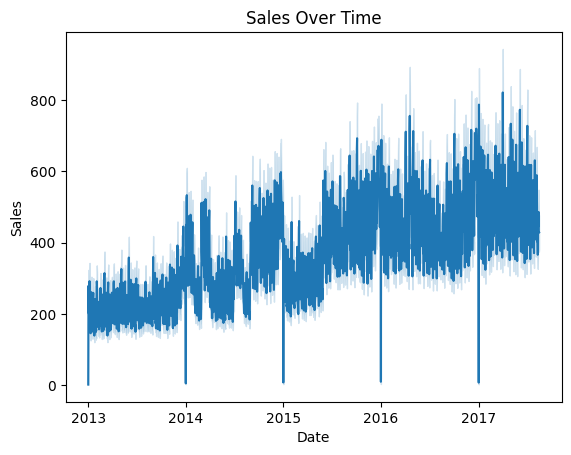

In [2]:
sns.lineplot(x='date', y='sales', data=data)
plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('Sales Over Time')
plt.show()

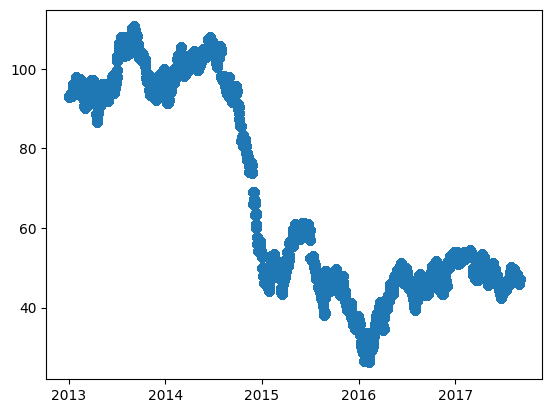

In [3]:
plt.scatter(x=data['date'], y=data['dcoilwtico'])

In [24]:
data['holiday_type'].unique()
data['family'].unique()

array(['AUTOMOTIVE', 'BABY CARE', 'BEAUTY', 'BEVERAGES', 'BOOKS',
       'BREAD/BAKERY', 'CELEBRATION', 'CLEANING', 'DAIRY', 'DELI', 'EGGS',
       'FROZEN FOODS', 'GROCERY I', 'GROCERY II', 'HARDWARE',
       'HOME AND KITCHEN I', 'HOME AND KITCHEN II', 'HOME APPLIANCES',
       'HOME CARE', 'LADIESWEAR', 'LAWN AND GARDEN', 'LINGERIE',
       'LIQUOR,WINE,BEER', 'MAGAZINES', 'MEATS', 'PERSONAL CARE',
       'PET SUPPLIES', 'PLAYERS AND ELECTRONICS', 'POULTRY',
       'PREPARED FOODS', 'PRODUCE', 'SCHOOL AND OFFICE SUPPLIES',
       'SEAFOOD'], dtype=object)

In [20]:
a = data.groupby("family").sales.mean().sort_values(ascending = False).reset_index()
px.bar(a, y = "family", x="sales", color = "family", title = "Product preferences")

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

Figure({
    'data': [{'alignmentgroup': 'True',
              'hovertemplate': 'family=%{y}<br>sales=%{x}<extra></extra>',
              'legendgroup': 'GROCERY I',
              'marker': {'color': '#636efa', 'pattern': {'shape': ''}},
              'name': 'GROCERY I',
              'offsetgroup': 'GROCERY I',
              'orientation': 'h',
              'showlegend': True,
              'textposition': 'auto',
              'type': 'bar',
              'x': array([3790.43279733]),
              'xaxis': 'x',
              'y': array(['GROCERY I'], dtype=object),
              'yaxis': 'y'},
             {'alignmentgroup': 'True',
              'hovertemplate': 'family=%{y}<br>sales=%{x}<extra></extra>',
              'legendgroup': 'BEVERAGES',
              'marker': {'color': '#EF553B', 'pattern': {'shape': ''}},
              'name': 'BEVERAGES',
              'offsetgroup': 'BEVERAGES',
              'orientation': 'h',
              'showlegend': True,
              'textposition': 'auto',
              'type': 'bar',
              'x': array([2394.9127015]),
              'xaxis': 'x',
              'y': array(['BEVERAGES'], dtype=object),
              'yaxis': 'y'},
             {'alignmentgroup': 'True',
              'hovertemplate': 'family=%{y}<br>sales=%{x}<extra></extra>',
              'legendgroup': 'PRODUCE',
              'marker': {'color': '#00cc96', 'pattern': {'shape': ''}},
              'name': 'PRODUCE',
              'offsetgroup': 'PRODUCE',
              'orientation': 'h',
              'showlegend': True,
              'textposition': 'auto',
              'type': 'bar',
              'x': array([1355.37369836]),
              'xaxis': 'x',
              'y': array(['PRODUCE'], dtype=object),
              'yaxis': 'y'},
             {'alignmentgroup': 'True',
              'hovertemplate': 'family=%{y}<br>sales=%{x}<extra></extra>',
              'legendgroup': 'CLEANING',
              'marker': {'color': '#ab63fa', 'pattern': {'shape': ''}},
              'name': 'CLEANING',
              'offsetgroup': 'CLEANING',
              'orientation': 'h',
              'showlegend': True,
              'textposition': 'auto',
              'type': 'bar',
              'x': array([1074.17151778]),
              'xaxis': 'x',
              'y': array(['CLEANING'], dtype=object),
              'yaxis': 'y'},
             {'alignmentgroup': 'True',
              'hovertemplate': 'family=%{y}<br>sales=%{x}<extra></extra>',
              'legendgroup': 'DAIRY',
              'marker': {'color': '#FFA15A', 'pattern': {'shape': ''}},
              'name': 'DAIRY',
              'offsetgroup': 'DAIRY',
              'orientation': 'h',
              'showlegend': True,
              'textposition': 'auto',
              'type': 'bar',
              'x': array([711.17599075]),
              'xaxis': 'x',
              'y': array(['DAIRY'], dtype=object),
              'yaxis': 'y'},
             {'alignmentgroup': 'True',
              'hovertemplate': 'family=%{y}<br>sales=%{x}<extra></extra>',
              'legendgroup': 'BREAD/BAKERY',
              'marker': {'color': '#19d3f3', 'pattern': {'shape': ''}},
              'name': 'BREAD/BAKERY',
              'offsetgroup': 'BREAD/BAKERY',
              'orientation': 'h',
              'showlegend': True,
              'textposition': 'auto',
              'type': 'bar',
              'x': array([464.15061157]),
              'xaxis': 'x',
              'y': array(['BREAD/BAKERY'], dtype=object),
              'yaxis': 'y'},
             {'alignmentgroup': 'True',
              'hovertemplate': 'family=%{y}<br>sales=%{x}<extra></extra>',
              'legendgroup': 'POULTRY',
              'marker': {'color': '#FF6692', 'pattern': {'shape': ''}},
              'name': 'POULTRY',
              'offsetgroup': 'POULTRY',
              'orientation': 'h',
              'showlegend': True,
              'textposition': 'auto',
              'type': 'bar',

In [6]:
dummies = pd.get_dummies(data[['store_nbr', 'family', 'sales', 'onpromotion',
       'holiday_type', 'locale', 'locale_name', 'description', 'transferred',
       'city', 'state', 'city_type', 'cluster', 'transactions', 'dcoilwtico']])

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
dummies[['store_nbr', 'sales', 'onpromotion', 'transferred',
         'cluster', 'transactions', 'dcoilwtico']] = scaler.fit_transform(dummies[[
                'store_nbr', 'sales', 'onpromotion', 'transferred', 'cluster',
                'transactions', 'dcoilwtico']])

In [26]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder

dummies[['holiday_type']] = data[['holiday_type']]
dummies[['family']] = data[['family']]

filtered_train_data = dummies[data['date'] <= '2017-08-15']
filtered_test_data = dummies[data['date'] > '2017-08-15']

x_train = filtered_train_data[['store_nbr', 'dcoilwtico', 'transactions']]
x_test = filtered_test_data[['store_nbr', 'dcoilwtico', 'transactions']]
y_train = filtered_train_data['sales']

# Perform one-hot encoding on the 'holiday_type' column
encoder = OneHotEncoder(sparse=False, drop='first')
holiday_type_encoded = encoder.fit_transform(filtered_train_data[['holiday_type']])
x_train = np.hstack((x_train.values, holiday_type_encoded))

holiday_type_encoded = encoder.transform(filtered_test_data[['holiday_type']])
x_test = np.hstack((x_test.values, holiday_type_encoded))

# Perform one-hot encoding on the 'family' column
family_encoder = OneHotEncoder(sparse=False, drop='first')
family_encoded_train = family_encoder.fit_transform(filtered_train_data[['family']])
x_train = np.hstack((x_train, family_encoded_train))

family_encoded_test = family_encoder.transform(filtered_test_data[['family']])
x_test = np.hstack((x_test, family_encoded_test))

scaled_X_train = scaler.fit_transform(x_train)
scaled_X_test = scaler.transform(x_test)

# Fit the model and predict sales
model = LinearRegression()
model.fit(scaled_X_train, y_train)
predicted_sales = model.predict(scaled_X_test)

# Create the submission DataFrame
submission = pd.DataFrame({'id': filtered_test_data.index, 'sales': predicted_sales})
submission.to_csv('submission.csv', index=False)


c:\Users\valac\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning:

`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.

c:\Users\valac\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning:

`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.

